# ParSNIP-PZ demonstration

This notebook probes the ParSNIP-PZ model on datasets with photometric redshifts including:
* Showing the redshifts that are recovered by ParSNIP-PZ
* Demonstrating its classification performance.
* Sampling from the posterior to show how well redshift is constrained.

# Load the datasets and models

In [1]:
# Import required packages
from astropy.table import Table
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import roc_curve, auc
import corner
import lcdata
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import parsnip
import sncosmo

# Load data

In [2]:
# Load the model and predictions to use for these analyses.
model = parsnip.load_model('../models/parsnip_plasticc_photoz.pt')

predictions_train = Table.read('../predictions/parsnip_predictions_plasticc_photoz_train_aug_100.h5')
predictions_test = Table.read('../predictions/parsnip_predictions_plasticc_photoz_test.h5')

In [3]:
# Make an output directory for figures if it doesn't exist
!mkdir -p ./figures_pz

## Photometric redshift statistics

In [4]:
def calculate_pz_stats(predictions):
    dz_parsnip = (predictions['predicted_redshift'] - predictions['redshift']) / (1 + predictions['predicted_redshift'])
    dz_photoz = (predictions['hostgal_photoz'] - predictions['redshift']) / (1 + predictions['hostgal_photoz'])

    def iqr(x):
        return (np.percentile(x, 75) - np.percentile(x, 25)) / 1.349

    print(f"IQR Host Galaxy PZ:     {iqr(dz_photoz):.4f}")
    print(f"IQR ParSNIP-PZ:         {iqr(dz_parsnip):.4f}")
    print(f"Outlier Host Galaxy PZ: {np.mean(np.abs(dz_photoz) > 0.06):.4f}")
    print(f"Outlier ParSNIP-PZ:     {np.mean(np.abs(dz_parsnip) > 0.06):.4f}")
    
    plot_pz(predictions)

def plot_pz(pred):
    fig = plt.figure(figsize=(10, 5), dpi=100)

    ax1, ax2 = ImageGrid(
        fig,
        111,
        nrows_ncols=(1, 2),
        axes_pad=0.15,
        share_all=True,
        cbar_location="right",
        cbar_mode="single",
        cbar_size="5%",
        cbar_pad=0.15,
    )

    norm = colors.LogNorm(vmin=1)
    cmap = plt.cm.magma_r

    ax1.set_aspect('equal')
    hist1 = ax1.hist2d(pred['hostgal_photoz'], pred['redshift'], 200, ((0, 2.999), (0, 2.999)), norm=norm, cmap=cmap)
    ax1.set_title('Host Galaxy')
    ax1.set_xlabel('Photometric Redshift')
    ax1.set_ylabel('True Redshift')
    

    ax2.set_aspect('equal')
    hist2 = ax2.hist2d(pred['predicted_redshift'], pred['redshift'], 200, ((0, 2.999), (0, 2.999)), norm=norm, cmap=cmap)
    ax2.set_title('ParSNIP-PZ')
    ax2.set_xlabel('Photometric Redshift')
    ax2.tick_params('y', labelleft=False)

    norm.vmax = np.max([hist1[0], hist2[0]])

    ax2.cax.colorbar(hist1[-1], label='Number of Objects')

IQR Host Galaxy PZ:     0.0286
IQR ParSNIP-PZ:         0.0244
Outlier Host Galaxy PZ: 0.1744
Outlier ParSNIP-PZ:     0.1018


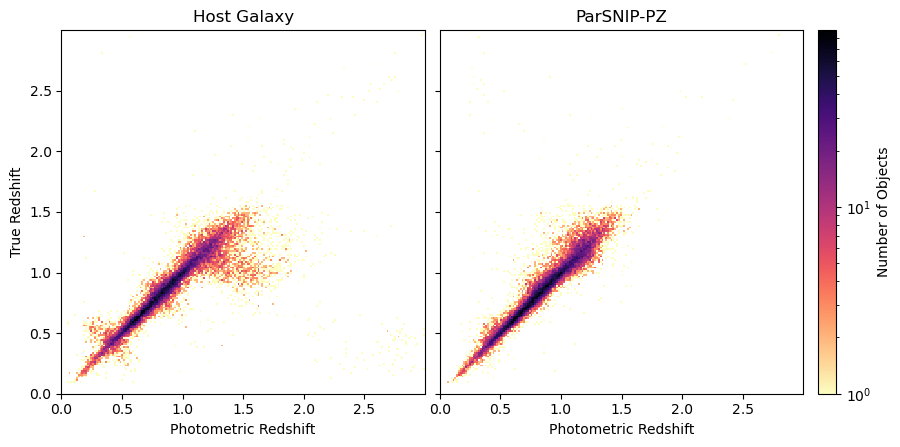

In [5]:
# DDF examples.
# We reject any transients that have a spec-z as this was used in the training and could
# be overfit. We are then only looking at objects whose redshift was not included in the
# training.
use_predictions = predictions_test[np.isnan(predictions_test['hostgal_specz'])
                                   & (predictions_test['ddf_bool'] == 1)]
calculate_pz_stats(use_predictions)

IQR Host Galaxy PZ:     0.0255
IQR ParSNIP-PZ:         0.0231
Outlier Host Galaxy PZ: 0.1615
Outlier ParSNIP-PZ:     0.1049


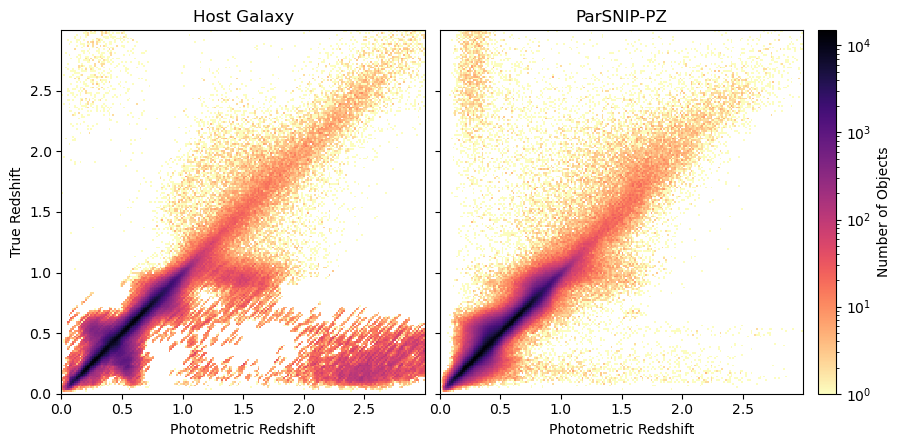

In [6]:
# WFD examples
use_predictions = predictions_test[np.isnan(predictions_test['hostgal_specz'])
                                   & (predictions_test['ddf_bool'] == 0)]
calculate_pz_stats(use_predictions)
plt.savefig('./figures_pz/photoz_recovery.pdf')

IQR Host Galaxy PZ:     0.0296
IQR ParSNIP-PZ:         0.0178
Outlier Host Galaxy PZ: 0.1997
Outlier ParSNIP-PZ:     0.0303


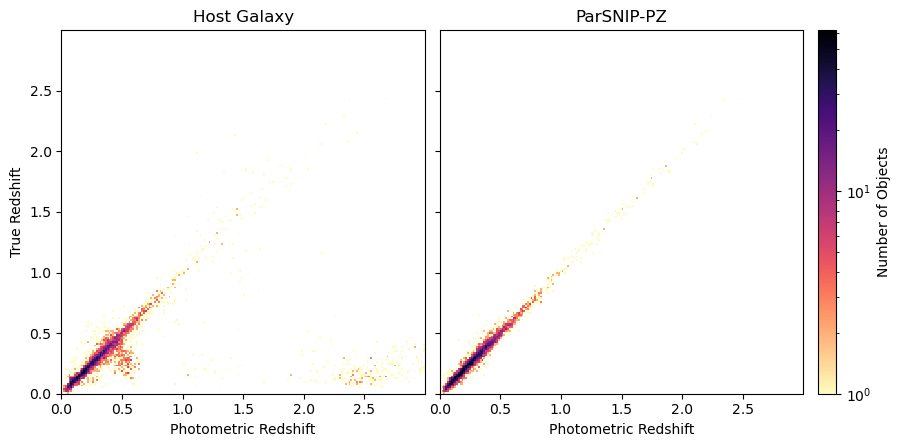

In [7]:
# Training dataset
# Note: the speczs from these transients were used when training the
# model, so the dataset is highly overfit.
calculate_pz_stats(predictions_train[~predictions_train['augmented']])

# Classification

In [8]:
# Select which types to include in the comparisons
use_types = ['KN', 'SLSN-I', 'SNII', 'SNIa', 'SNIa-91bg', 'SNIax', 'SNIbc', 'TDE']

In [9]:
# Classify the dataset using ParSNIP-PZ
classifier = parsnip.Classifier()

# Add a key representing the difference between the host galaxy PZ and the ParSNIP PZ.
predictions_train['diff_z'] = predictions_train['hostgal_photoz'] - predictions_train['predicted_redshift']
predictions_test['diff_z'] = predictions_test['hostgal_photoz'] - predictions_test['predicted_redshift']

# Add a key representing the model chi-square per degree of freedom.
predictions_train['chisq_dof'] = predictions_train['model_chisq'] / np.clip(predictions_train['model_dof'], 1, None)
predictions_test['chisq_dof'] = predictions_test['model_chisq'] / np.clip(predictions_test['model_dof'], 1, None)

classifier.keys.append('diff_z')
classifier.keys.append('chisq_dof')

classifications_train = classifier.train(predictions_train)
classifications_test = classifier.classify(predictions_test)

mask = np.isin(predictions_test['type'], np.char.encode(use_types))

parsnip_predictions = predictions_test[mask]
parsnip_classifications = classifications_test[mask]

Training classifier with keys:
    color
    color_error
    s1
    s1_error
    s2
    s2_error
    s3
    s3_error
    luminosity
    luminosity_error
    reference_time_error
    diff_z
    chisq_dof
[100]	valid_0's multi_logloss: 0.556015
[100]	valid_0's multi_logloss: 0.584712
[100]	valid_0's multi_logloss: 0.588907
[100]	valid_0's multi_logloss: 0.633696
[100]	valid_0's multi_logloss: 0.517678
[100]	valid_0's multi_logloss: 0.584445
[100]	valid_0's multi_logloss: 0.585225
[100]	valid_0's multi_logloss: 0.572817
[100]	valid_0's multi_logloss: 0.601017
[100]	valid_0's multi_logloss: 0.616697


In [10]:
# Load Avocado classifications
avocado_classifications = pd.read_hdf('../predictions/predictions_plasticc_test_flat_weight.h5', key='predictions')

# Rename columns
label_map = {
    90: 'SNIa',
    67: 'SNIa-91bg',
    52: 'SNIax',
    42: 'SNII',
    62: 'SNIbc',
    95: 'SLSN-I',
    15: 'TDE',
    64: 'KN',
    88: 'AGN',
    92: 'RRL',
    65: 'M-dwarf',
    16: 'EB',
    53: 'Mira',
    6: 'uLens-Single',
    991: 'uLens-Binary',
    992: 'ILOT',
    993: 'CaRT',
    994: 'PISN',
}
avocado_classifications.rename(columns=label_map, inplace=True)

# Select the same subset of columns and rows as we used for Parsnip
plasticc_object_ids = np.array([i.lower().replace(' ', '_') for i in parsnip_predictions['object_id']])
avocado_classifications = avocado_classifications.loc[plasticc_object_ids, use_types]

# Renormalize classification probabilities
avocado_classifications = avocado_classifications.div(avocado_classifications.sum(axis=1), axis=0)

# Convert to an astropy Table
avocado_classifications = Table.from_pandas(avocado_classifications, index=True)

In [11]:
classifications = {
    'ParSNIP-PZ': parsnip_classifications,
    'Avocado': avocado_classifications,
}

Macro averaged completeness (Villar et al. 2020): 0.7677
Fraction correct: 0.7665
Macro averaged completeness (Villar et al. 2020): 0.7472
Fraction correct: 0.7439


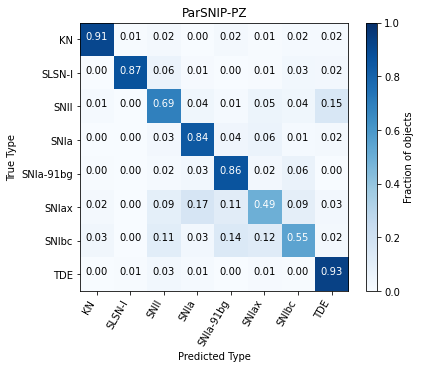

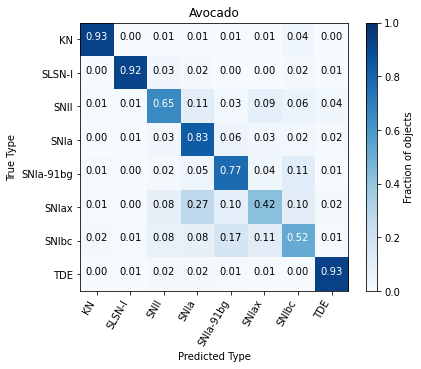

In [12]:
# Show confusion matrices.
for label, classification in classifications.items():
    parsnip.plot_confusion_matrix(
        parsnip_predictions,
        classification,
        figsize=(6, 5),
        title=label
    )
    lower_label = label.lower().replace('-', '_')
    plt.savefig(f'./figures_pz/confusion_matrix_{lower_label}.pdf')

In [13]:
# Evaluate the PLAsTiCC metric (Malz et al. 2019)
for label, classification in classifications.items():
    parsnip_metric = parsnip.weighted_multi_logloss(parsnip_predictions['type'], classification)
    print(f"{label:10s} {parsnip_metric:.4f}")

ParSNIP-PZ 0.6579
Avocado    0.6958


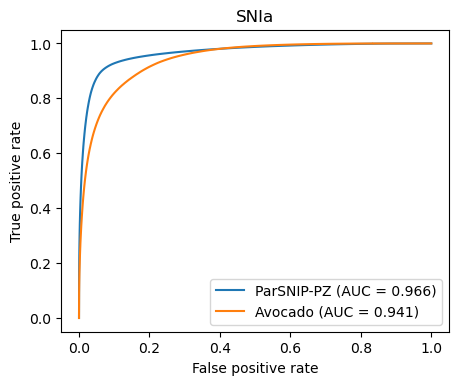

In [14]:
# Show the ROC curve for Type Ia supernovae
use_type = 'SNIa'

plt.figure(figsize=(5, 4), dpi=100)

for label, classification in classifications.items():
    fpr, tpr, thresholds = roc_curve(parsnip_predictions['type'] == use_type, classification[use_type])
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc(fpr, tpr):.3f})')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.legend()
plt.title(use_type)

plt.savefig('./figures_pz/roc_snia_comparison.pdf')

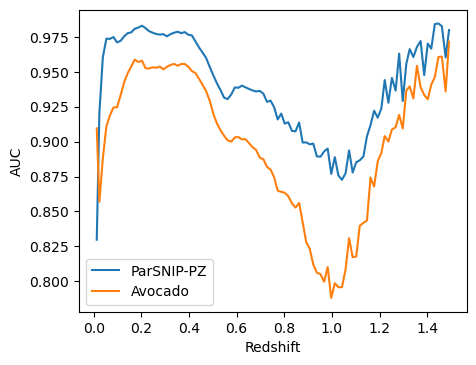

In [19]:
# Show the redshift dependent AUC for Type Ia supernovae
def plot_auc(target, pred, key, label, num_bins=100, binrange=None):
    val = parsnip_predictions[key]

    xvals = []
    aucs = []

    if binrange is None:
        bins = np.linspace(0, 100, num_bins+1)
    else:
        bins = np.linspace(binrange[0], binrange[1], num_bins+1)

    for bin_idx in range(num_bins):
        if binrange is None:
            cut = (val >= np.percentile(val, bins[bin_idx])) & (val < np.percentile(val, bins[bin_idx + 1]))
        else:
            cut = (val > bins[bin_idx]) & (val < bins[bin_idx + 1])

        cut_target = target[cut]
    
        if len(cut_target) == 0 or np.all(cut_target) or not np.any(cut_target):
            # All entries are from the same class. Can't compute a ROC curve
            continue

        fpr, tpr, thresholds = roc_curve(cut_target, pred[cut])
        aucs.append(auc(fpr, tpr))

        xvals.append(np.mean(val[cut]))

    plt.plot(xvals, aucs, label=label)
    plt.xlabel(key)
    plt.ylabel('AUC')
    plt.legend()

plt.figure(figsize=(5, 4), dpi=100)
for label, classification in classifications.items():
    plot_auc(parsnip_predictions['type'] == 'SNIa', classification['SNIa'], 'redshift', label, binrange=(0, 1.5))
plt.xlabel('Redshift')

plt.savefig('./figures_pz/auc_vs_redshift.pdf')

# MCMC of the posterior distribution

In [16]:
def gaussian(x):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-x**2 / 2)

def mcmc_posterior(lc, nwalkers=20, **kwargs):
    lc = parsnip.preprocess_light_curve(lc, model.settings)
    lc = lcdata.to_sncosmo(lc)

    # Add the error floor so that we can compare directly to the results from running
    # through our model.
    scale = lc.meta['parsnip_scale']
    lc['fluxerr'] = np.sqrt(lc['fluxerr']**2 + (scale * model.settings['error_floor'])**2)

    # Do variational inference to predict the model parameters, and instantiate an SNCosmo model
    # with those parameters.
    sncosmo_model = model.predict_sncosmo(lc)

    # Include the priors on the latent variables.
    priors = {
        's1': gaussian,
        's2': gaussian,
        's3': gaussian,
    }

    parameters = ['z', 't0', 'amplitude', 'color', 's1', 's2', 's3']

    # Run MCMC to evaluate the full posterior of a light curve.
    emcee_result, fitted_model = sncosmo.mcmc_lc(
        lc,
        sncosmo_model,
        parameters,
        priors=priors,
        nwalkers=nwalkers,
        bounds={'z': (0.5 * sncosmo_model['z'], 1.5 * sncosmo_model['z'])},
        **kwargs,
    )

    # Make a corner plot of the results.
    corner.corner(
        emcee_result['samples'],
        labels=['Redshift', 'Reference Time', 'Amplitude', 'Color', '$s_1$', '$s_2$', '$s_3$']
    )

    # Compare the uncertainties from the predictions.
    lc_predictions = model.predict(lc)
    parsnip_uncertainties = [
        lc_predictions['predicted_redshift_error'],
        lc_predictions['reference_time_error'],
        lc_predictions['amplitude_error'] * 10**(-0.4 * 45),
        lc_predictions['color_error'],
        lc_predictions['s1_error'],
        lc_predictions['s2_error'],
        lc_predictions['s3_error'],
    ]

    # Print a comparsion of the model parameters
    tab = Table({
        'Parameter': parameters,
        'ParSNIP prediction': [sncosmo_model[i] for i in parameters],
        'MCMC prediction': [fitted_model[i] for i in parameters],
        'ParSNIP uncertainty': parsnip_uncertainties,
        'MCMC uncertainty': np.sqrt(np.diag(emcee_result['covariance'])),
    })

    return tab

In [17]:
dataset = parsnip.load_dataset('../data/plasticc_combined.h5', in_memory=False)

Parsing 'plasticc_combined.h5' as PLAsTiCC dataset...
Rejecting 53226 non-supernova-like light curves.
Dataset contains 338839 light curves.


CPU times: user 1h 37min 50s, sys: 1min 29s, total: 1h 39min 19s
Wall time: 12min 29s


Parameter,ParSNIP prediction,MCMC prediction,ParSNIP uncertainty,MCMC uncertainty
str9,float64,float64,float64,float64
z,0.9426122307777405,0.926504374130947,0.009063571691513062,0.032445215803355965
t0,60571.76267946003,60571.55355998137,0.6328362226486206,0.8140231297310434
amplitude,3.3834442496299747e-19,4.1425624376824774e-19,8.94687045365572e-21,1.3216160052234788e-19
color,-0.03679528832435608,-0.0034129944868253226,0.058091457933187485,0.07898239093826936
s1,0.023604314774274826,-0.06102447571604843,0.9571253061294556,1.0094618153226336
s2,0.5579319596290588,0.7116855727704482,0.2744550406932831,0.23823037872689007
s3,0.2397742122411728,0.05415920278014969,0.712695837020874,0.8482172888664862


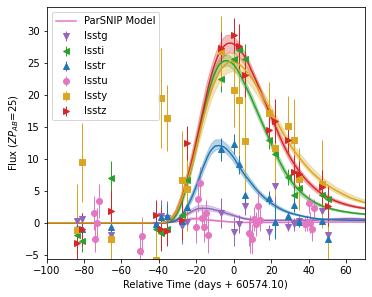

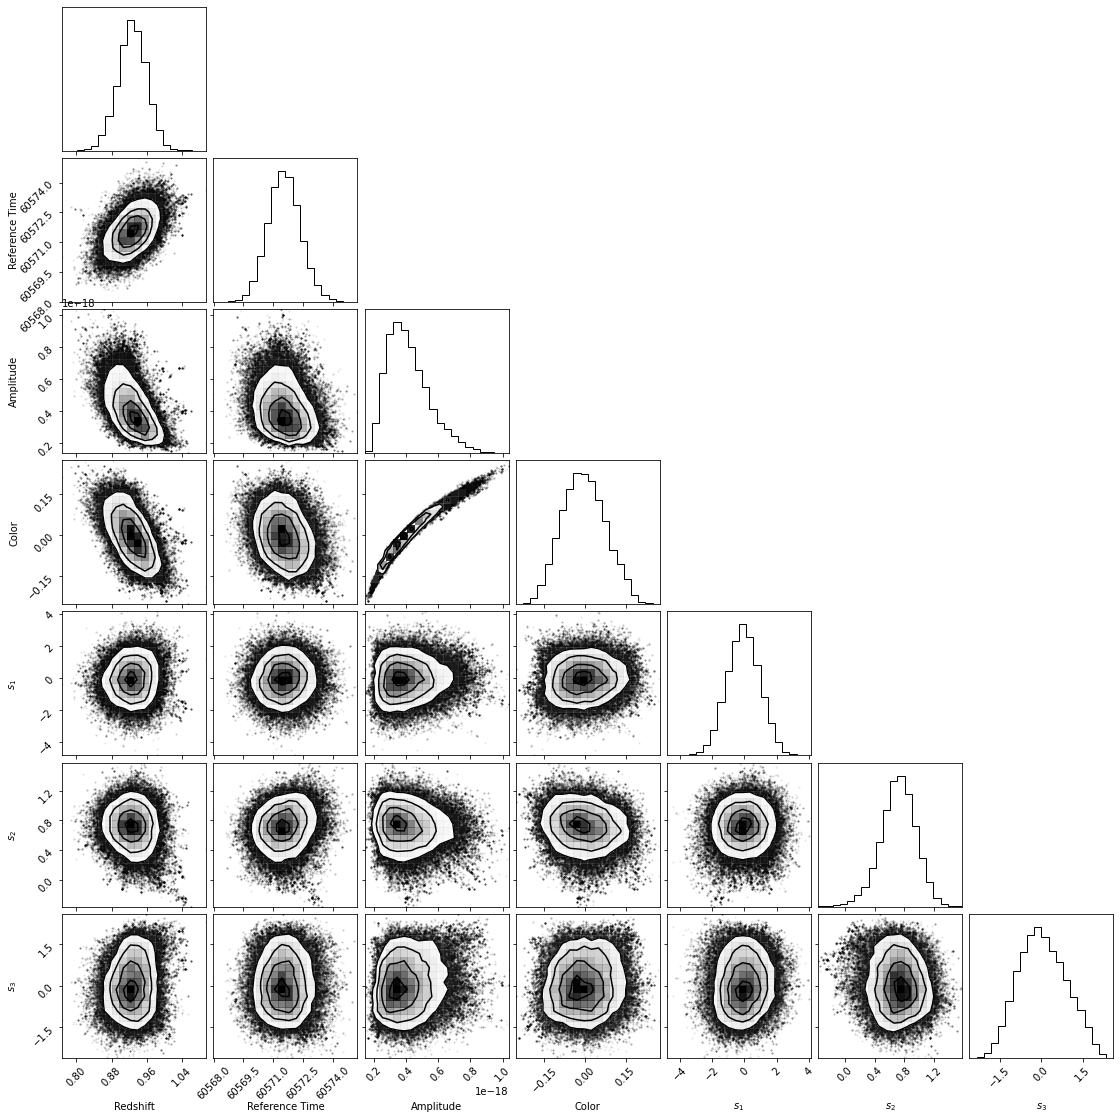

In [18]:
%%time
lc = dataset.get_lc('PLAsTiCC 000000060')
parsnip.plot_light_curve(lc, model)
plt.xlim(-100, 70)
plt.savefig('./figures_pz/mcmc_lc_1.pdf')

result = mcmc_posterior(lc, nsamples=10000, nburn=1000)
plt.savefig('./figures_pz/mcmc_redshift_posterior_1.pdf')
result